# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import datetime 
import seaborn as sns

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict


### 1b. Load the data
Call the variable `cigData`. 

In [3]:
cigData = pd.read_csv('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [4]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [5]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [6]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [7]:
cigData.isnull().values.any()

False

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [8]:
cigData.drop(columns='Unnamed: 0',inplace=True) 

In [9]:
cigData.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [10]:
cigData.rename(columns={'Time':'Month'},inplace=True)

Call a head() to check this has worked. 

In [11]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [12]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [13]:
cigData['Month'] = pd.to_datetime(cigData['Month'])

In [14]:
cigData.dtypes

Month        datetime64[ns]
#CigSales             int64
dtype: object

In [15]:
# Setting Month column as Index
cigData.set_index('Month', inplace=True)

In [16]:
cigData.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [17]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   #CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [18]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [19]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [20]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

In [21]:
y.head()

Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
Name: #CigSales, dtype: int64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

Text(0, 0.5, 'Sales in Million')

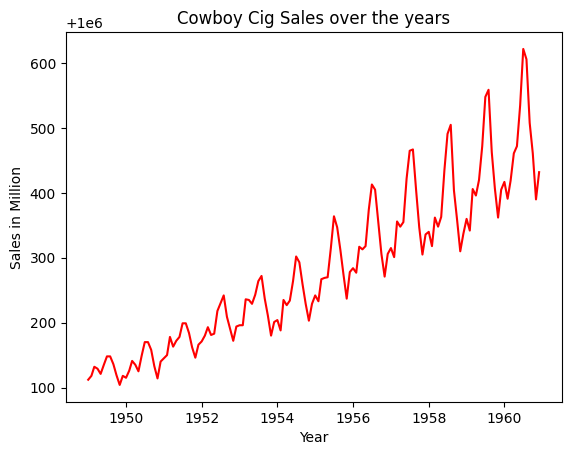

In [22]:
plt.plot(y.index,y, color='red')

plt.title('Cowboy Cig Sales over the years')

plt.xlabel('Year')
plt.ylabel('Sales in Million')

## Making a copy to manipulate to extract months and visualize seasonality in sales

In [23]:
seasonal_data = cigData.copy()

In [24]:
seasonal_data.head()

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


In [25]:
seasonal_data['Date'] = seasonal_data.index

In [26]:
seasonal_data.head()

,#CigSales,Date
Month,,
1949-01-01,1000112,1949-01-01
1949-02-01,1000118,1949-02-01
1949-03-01,1000132,1949-03-01
1949-04-01,1000129,1949-04-01
1949-05-01,1000121,1949-05-01


In [27]:
seasonal_data['Months'] = seasonal_data['Date'].dt.month

In [28]:
seasonal_data.head()

,#CigSales,Date,Months
Month,,,
1949-01-01,1000112,1949-01-01,1
1949-02-01,1000118,1949-02-01,2
1949-03-01,1000132,1949-03-01,3
1949-04-01,1000129,1949-04-01,4
1949-05-01,1000121,1949-05-01,5


/var/folders/yw/y4pg_jgd1337cpj1cjwrm82c0000gn/T/ipykernel_964/4236716652.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Months', y='#CigSales', data=seasonal_data, ax=ax, palette='Set3')
/var/folders/yw/y4pg_jgd1337cpj1cjwrm82c0000gn/T/ipykernel_964/4236716652.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([


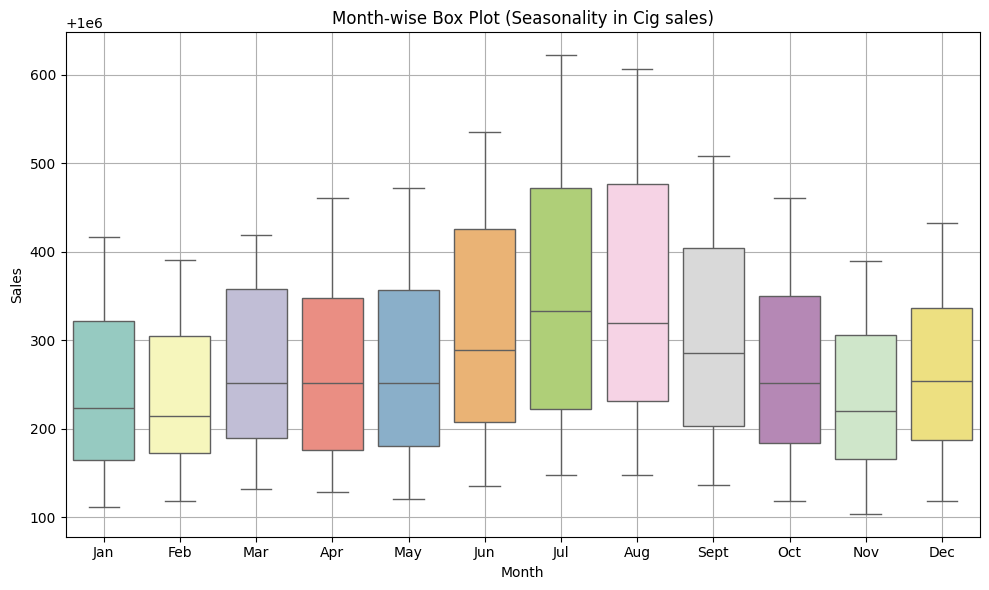

In [29]:
months_grouped_ = seasonal_data['Months']


#  Create box plots
fig, ax = plt.subplots(figsize=(10, 6))

# Group the data by month and create a box plot for each month's values

sns.boxplot(x='Months', y='#CigSales', data=seasonal_data, ax=ax, palette='Set3')

# Customize the plot
#ax.set_xticklabels(seasonal_data['Months'].unique())  # Set x-axis labels to unique years
ax.set_xlabel('Month')  # Set x-axis label
ax.set_ylabel('Sales')  # Set y-axis label
ax.set_title('Month-wise Box Plot (Seasonality in Cig sales)')  # Set plot title
ax.set_xticklabels([
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'
    ])#This code changes the values from numeric to the corresponding acronyms :)

# adding grid lines 
ax.grid(True)
plt.tight_layout()
plt.show()

## Observations:

Cigarette sales increase during the summer months; June, July and August. 

Hypothesis: Sales increase during summer months becuase time spent outdoors also increases. 

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y, model='multiplicative')

# Plot the original data, the trend, the seasonality, and the residuals 
#decomposition.plot()

In [31]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


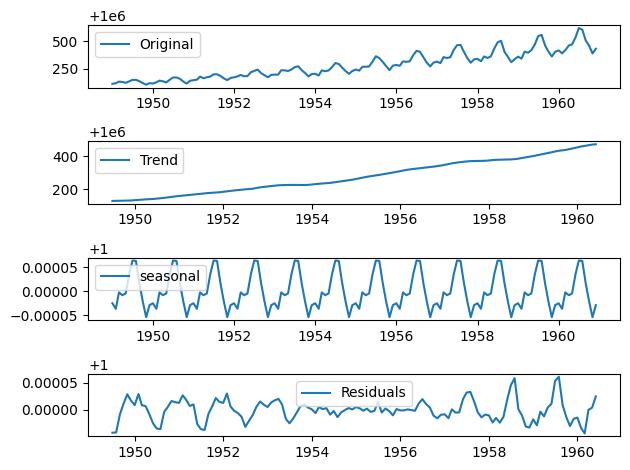

In [32]:
# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [33]:
from statsmodels.tsa.stattools import kpss
#kpss(y)

In [62]:

statistic, p_value, lags, critical_values = kpss(y, regression='c')

print("KPSS Statistic:", statistic)
print("p-value:", p_value)
print("Critical Values:", critical_values)

KPSS Statistic: 1.651312235417082
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

Text(0, 0.5, 'Sales in Million')

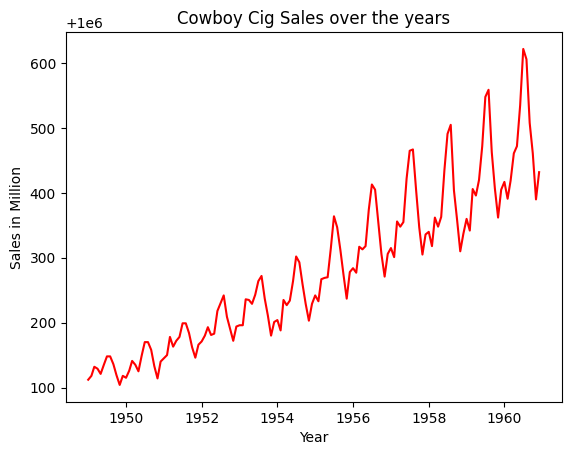

In [35]:
plt.plot(y, color='red')

plt.title('Cowboy Cig Sales over the years')

plt.xlabel('Year')
plt.ylabel('Sales in Million')

In [36]:
from scipy.stats import boxcox

In [37]:
cigData.head()

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


In [38]:
! pip install nbformat --upgrade



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [39]:
import plotly.express as px


def plot_CigSales_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x=df.index, y=y,)
   

    return fig.show()


# Plot the airline passenger data
plot_CigSales_volumes(df=cigData, y='#CigSales')

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [40]:
# Note: Make sure your data has no zero or negative values before applying the log transform

log_y = np.log(y +1)

# np.log computes the natural log of each value 

# applymap() applies np.log() function to every element in the df

In [41]:
print(log_y.head())

Month
1949-01-01    13.815624
1949-02-01    13.815630
1949-03-01    13.815644
1949-04-01    13.815641
1949-05-01    13.815633
Name: #CigSales, dtype: float64


In [42]:
log_y.describe()

count    144.000000
mean      13.815792
std        0.000120
min       13.815616
25%       13.815692
50%       13.815777
75%       13.815872
max       13.816133
Name: #CigSales, dtype: float64

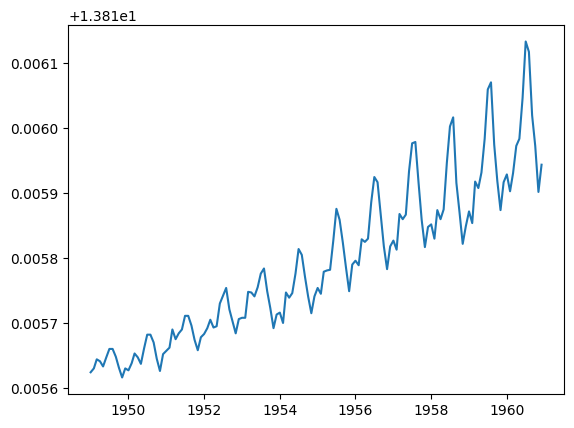

In [43]:
plt.plot(log_y)

In [63]:
result = adfuller(log_y)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary. Consider additional differencing or transformations.")

ADF Statistic: 0.8148180237178488
p-value: 0.9918716322633944
The series is not stationary. Consider additional differencing or transformations.



When you plot this, you can see how the variance in our data now remains contant over time.

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [64]:
log_diff = log_y.diff().dropna()

In [65]:
log_diff.head()

Month
1949-02-01    0.000006
1949-03-01    0.000014
1949-04-01   -0.000003
1949-05-01   -0.000008
1949-06-01    0.000014
Name: #CigSales, dtype: float64

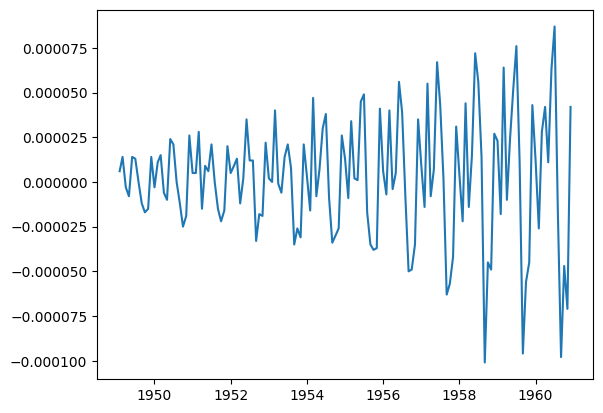

In [66]:
plt.plot(log_diff)

In [43]:
# Apply second-order differencing
#log_diff_2 = log_diff.diff().dropna()


In [67]:
statistic, p_value, lags, critical_values = kpss(log_diff)

print("KPSS Statistic:", statistic)
print("p-value:", p_value)
print("Critical Values:", critical_values)

KPSS Statistic: 0.02389767420746404
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [45]:
#import numpy as np

# Remove NaN and inf values from the data
#log_diff_2 = log_diff_2.replace([np.inf, -np.inf], np.nan)
#log_diff_2 = log_diff_2.dropna()


In [68]:


result = adfuller(log_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary. Consider additional differencing or transformations.")


ADF Statistic: -2.829562441568014
p-value: 0.054173485673031464
The series is not stationary. Consider additional differencing or transformations.


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [49]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [48]:
#Note: Had to drop down a tier to get help on how to do this
"""
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split= int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error
"""

"\n# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model \ndef evaluate_arima_model(data, arima_order):\n    # Needs to be an integer because it is later used as an index.\n    # Use int()\n    split= int(len(data) * 0.8) \n    # Make train and test variables, with 'train, test'\n    train, test = data[0:split], data[split:len(data)]\n    past=[x for x in train]\n    # make predictions\n    predictions = list()\n    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. \n        model = ARIMA(past, order=arima_order)\n        model_fit = model.fit(disp=0)\n        future = model_fit.forecast()[0]\n        predictions.append(future)\n        past.append(test[i])\n    # calculate out of sample error\n    error = mean_squared_error(test, predictions)\n    # Return the error\n    return error\n"

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [49]:
#Note: Had to drop down a tier to get help on how to do this
"""
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
"""

'\n# Make a function to evaluate different ARIMA models with several different p, d, and q values.\ndef evaluate_models(dataset, p_values, d_values, q_values):\n    best_score, best_cfg = float("inf"), None\n    #\xa0Iterate through p_values\n    for p in p_values:\n        # Iterate through d_values\n        for d in d_values:\n            # Iterate through q_values\n            for q in q_values:\n                # p, d, q iterator variables in that order\n                order = (p,d,q)\n                try:\n                    # Make a variable called mse for the Mean squared error\n                    mse = evaluate_arima_model(dataset, order)\n                    if mse < best_score:\n                        best_score, best_cfg = mse, order\n                    print(\'ARIMA%s MSE=%.3f\' % (order,mse))\n                except:\n                    continue\n    return print(\'Best ARIMA%s MSE=%.3f\' % (best_cfg, best_score))\n'

In [50]:
"""
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# Fill in the blanks as appropriate
p_values = [x for x in range(0,3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

"""

'\n# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values\n# Fill in the blanks as appropriate\np_values = [x for x in range(0,3)]\nd_values = [x for x in range(0, 3)]\nq_values = [x for x in range(0, 3)]\n\n'

In [70]:
# Import mean_squared_error and the updated ARIMA class
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA  # Updated import

# Function to evaluate a single ARIMA model
def evaluate_arima_model(data, arima_order):
    split = int(len(data) * 0.8)
    train, test = data[0:split], data[split:len(data)]
    past = [x for x in train]
    predictions = list()
    
    for i in range(len(test)):
        try:
            model = ARIMA(past, order=arima_order)
            model_fit = model.fit()
            future = model_fit.forecast()[0]
            predictions.append(future)
            past.append(test[i])
        except Exception as e:
            print(f"Error fitting ARIMA{arima_order}: {e}")
            return float("inf")
    
    error = mean_squared_error(test, predictions)
    return error

# Function to evaluate different ARIMA models
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except Exception as e:
                    print(f"Error evaluating ARIMA{order}: {e}")
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score

# Define parameter ranges
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 1)]
q_values = [x for x in range(0, 3)]

import warnings
warnings.filterwarnings("ignore")
# Example usage
evaluate_models(log_diff, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 0, 1) MSE=0.000
ARIMA(1, 0, 2) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 0, 1) MSE=0.000
ARIMA(2, 0, 2) MSE=0.000
Best ARIMA(2, 0, 1) MSE=0.000


((2, 0, 1), 2.2734414639958104e-09)

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [71]:
p= 2
d= 0
q= 1
model = ARIMA(log_diff, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

We can take a look at a summary of the model this library has built around our data.

In [72]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  143
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1287.929
Date:                Sun, 10 Nov 2024   AIC                          -2565.858
Time:                        19:17:41   BIC                          -2551.044
Sample:                    02-01-1949   HQIC                         -2559.838
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.354e-06   1.92e-06      0.705      0.481   -2.41e-06    5.12e-06
ar.L1          1.0672   1.88e-11   5.66e+10      0.000       1.067       1.067
ar.L2         -0.4449    2.4e-11  -1.86e+10      0.000      -0.445      -0.445
ma.L1         -0.7214   1.63e-11  -4.42e+10      0.000      -0.721      -0.721
sigma2      9.169e-10   2.91e-10      3.146      0.002    3.46e-10    1.49e-09
===================================================================================
Ljung-Box (L1) (Q):                   1.36   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.24   Prob(JB):                         0.75
Heteroskedasticity (H):               7.98   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+27. Standard errors may be unstable.
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

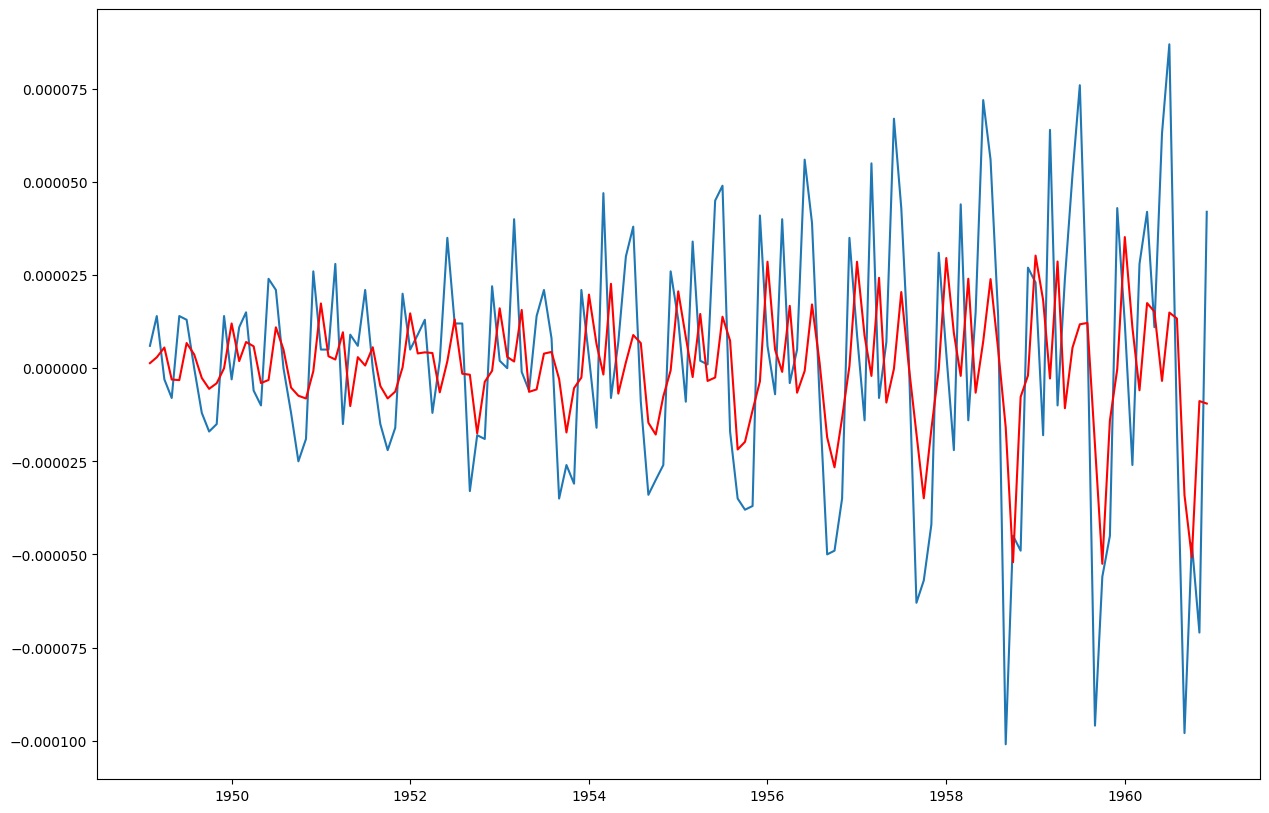

In [74]:
plt.figure(figsize=(15,10))
plt.plot(log_diff)
plt.plot(model_fit.predict(), color = 'red')

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

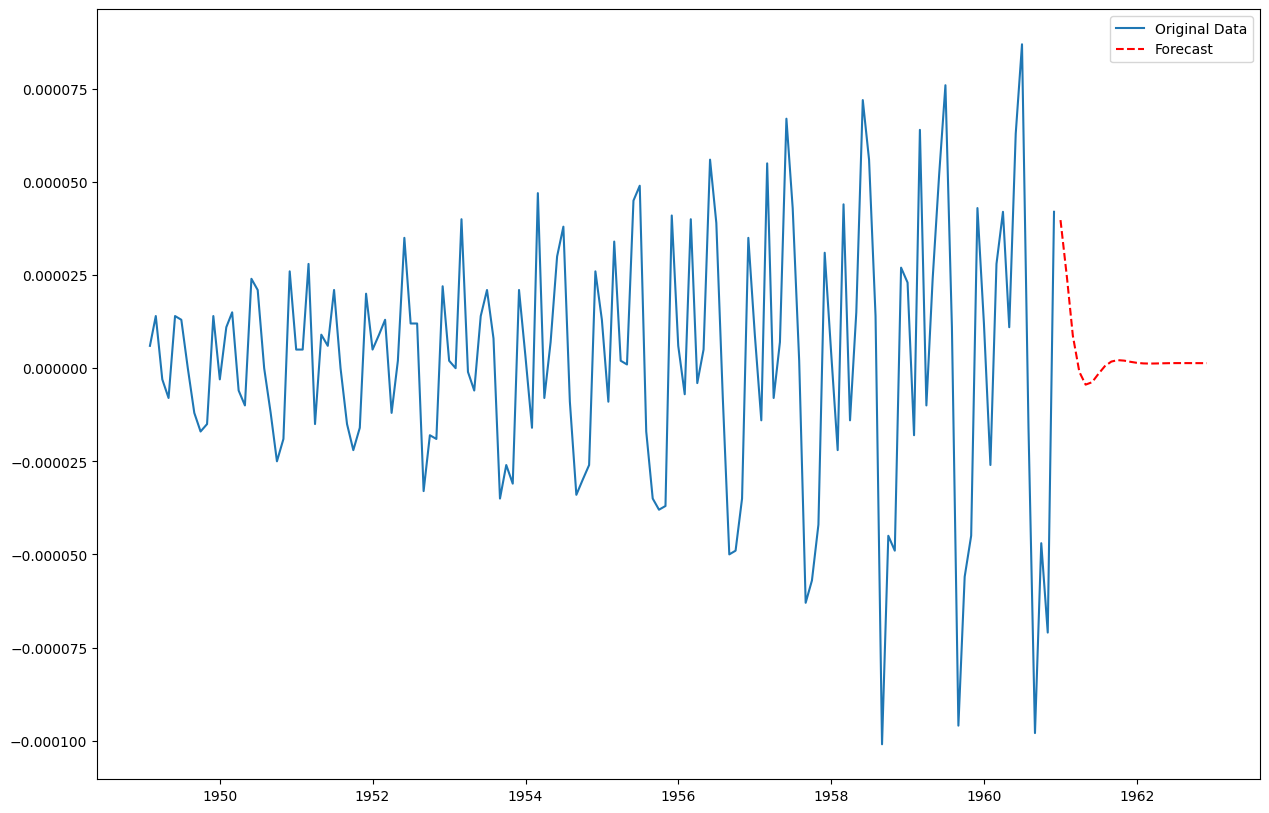

In [83]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(log_diff.index[-1], periods = forecast_period + 1, 
              freq='MS')[1:].strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Month'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast

# Concatenate the original log_diff series with future_months['Prediction']
combined_series = pd.concat([log_diff, pd.Series(future_months['Prediction'])])

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))

#plt.plot(log_diff['Nov 1960'].append(pd.Series(future_months['Prediction'])))

plt.plot(log_diff, label='Original Data')
#plt.plot(future_months['Prediction'])
plt.plot(future_months['Prediction'], label='Forecast', color='red', linestyle='--')
plt.legend()
plt.show()

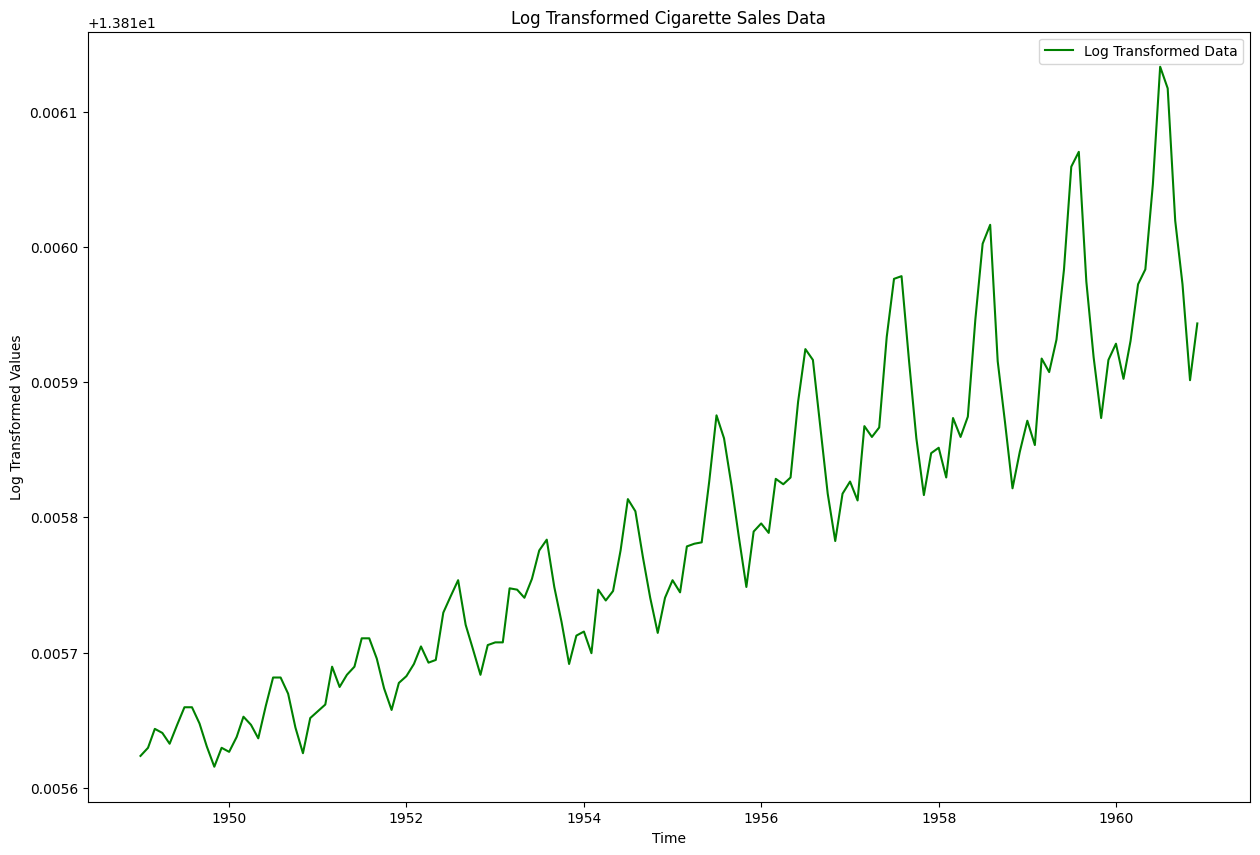

In [93]:
# Apply log transformation
cigData['CigSales_Log'] = np.log(cigData['#CigSales'] + 1)  # Adding 1 to avoid log(0)

# Plot the log-transformed data
plt.figure(figsize=(15, 10))
plt.plot(cigData.index, cigData['CigSales_Log'], label='Log Transformed Data', color='green')
plt.title('Log Transformed Cigarette Sales Data')
plt.xlabel('Time')
plt.ylabel('Log Transformed Values')
plt.legend()
plt.show()


In [96]:
# Import necessary packages
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Split the data into train and test sets
train = cigData.iloc[:-int(len(cigData) * 0.2)]
test = cigData.iloc[-int(len(cigData) * 0.2):]

# Build and fit the ARIMA model using the log-transformed data
model = ARIMA(train['CigSales_Log'], order=(2, 1, 2)).fit()

# Forecast for the length of the test set
log_forecasts = model.forecast(steps=len(test))

# Inverse the log transformation to get the forecasts back in the original scale
forecasts = np.exp(log_forecasts)

# Print or plot the forecasts
print(forecasts)


1958-09-01    1.000502e+06
1958-10-01    1.000498e+06
1958-11-01    1.000496e+06
1958-12-01    1.000495e+06
1959-01-01    1.000494e+06
1959-02-01    1.000494e+06
1959-03-01    1.000493e+06
1959-04-01    1.000493e+06
1959-05-01    1.000493e+06
1959-06-01    1.000493e+06
1959-07-01    1.000493e+06
1959-08-01    1.000493e+06
1959-09-01    1.000493e+06
1959-10-01    1.000493e+06
1959-11-01    1.000493e+06
1959-12-01    1.000493e+06
1960-01-01    1.000493e+06
1960-02-01    1.000493e+06
1960-03-01    1.000493e+06
1960-04-01    1.000493e+06
1960-05-01    1.000493e+06
1960-06-01    1.000493e+06
1960-07-01    1.000493e+06
1960-08-01    1.000493e+06
1960-09-01    1.000493e+06
1960-10-01    1.000493e+06
1960-11-01    1.000493e+06
1960-12-01    1.000493e+06
Freq: MS, Name: predicted_mean, dtype: float64


## Note: Got stuck and had to watch Youtube video that helped me create the graph below. 

In [97]:
# Import packages
import plotly.graph_objects as go

# Define the function to plot forecasts
def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    
    # Plot the training data
    fig.add_trace(go.Scatter(x=train.index, y=train['#CigSales'], name='Train'))
    
    # Plot the test data
    fig.add_trace(go.Scatter(x=test.index, y=test['#CigSales'], name='Test'))
    
    # Plot the forecasts
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast', line=dict(dash='dot')))
    
    # Update layout
    fig.update_layout(
        template="simple_white", 
        font=dict(size=18), 
        title_text=title,
        width=800, 
        title_x=0.5, 
        height=500, 
        xaxis_title='Date',
        yaxis_title='Cigarette Sales Volume'
    )

    return fig.show()

# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA Forecast for Cigarette Sales')


## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 